<a href="https://colab.research.google.com/github/elianasv/HNC_PREDICTION/blob/main/NewFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import simps  # For area under the curve
import warnings

# Ignore deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
#Set the path of the folder in drive to save the generated datasets and outputs
folder_datasets = '/content/drive/MyDrive/Tesis/DefinitiveDatasets'
folder_outputs = '/content/drive/MyDrive/Tesis/DefinitiveOutputs'

In [ ]:
#df_rem=pd.read_excel(r'/content/drive/MyDrive/Tesis/df_patiens_rem_reordered_renamed.xlsx')

In [3]:
# This URL leads to a Github repository containing the anonymized dataset with the random numbers already removed
filename = "https://github.com/elianasv/HNC_PREDICTION/raw/main/df_clean.xlsx"
df_rem = pd.read_excel(filename,engine='openpyxl')

In [4]:
# Define the features and comps
features = [
    'int_SUVMean_T_', 'int_SUVMean_N_', 'int_SUVVariance_T_', 'int_SUVVariance_N_',
    'int_SUVSkewness_T_', 'int_SUVSkewness_N_', 'int_SUVKurtosis_T_', 'int_SUVKurtosis_N_',
    'int_SUVPeak_T_', 'int_MTV_T_', 'int_MTV_N_', 'int_TLG_T_',
    'int_TLG_N_'
]

comps = ['abs', 'rel']

In [7]:
# Function to create a plot matrix for a specific stade, separating by DFS (excluding censored subjects)
def create_plot_matrix_by_DFS_no_censor(df, stade, axs):

    # Filter the subjects for the current stade first
    subjects = df[df['stade'] == stade]

    # Define the DFS categories, incorporating censoring information (excluding censored subjects)
    categories = {
        'DFS <= 1 year (Uncensored)': (subjects['DFS'] <= 12) & (subjects['DFSCensor'] == 1),
        '1 year < DFS < 2 years (Uncensored)': (subjects['DFS'] > 12) & (subjects['DFS'] <= 24) & (subjects['DFSCensor'] == 1),
        'DFS > 2 years (Uncensored)': (subjects['DFS'] > 24) & (subjects['DFSCensor'] == 1)
    }

    # Assign a color to each category
    colors = plt.cm.tab10(range(len(categories)))

    # Loop through each feature
    for i, feature in enumerate(features):
        # Each row represents a feature
        row = i  # Each feature gets its own row

        # Create four subplots in the row: (T_abs, T_rel, N_abs, N_rel)
        for j, (comp_T, comp_N) in enumerate(zip(['abs', 'rel'], ['abs', 'rel'])):
            # Prepare the subplot for T_ (abs, rel)
            ax_T = axs[row, j * 2]      # First two columns for T_ (abs, rel)
            ax_N = axs[row, j * 2 + 1]  # Last two columns for N_ (abs, rel)

            ax_T.set_xlabel('Threshold')
            ax_N.set_xlabel('Threshold')

            ax_T.set_ylabel(feature)
            ax_T.set_title(f'{feature} (T_) ({comp_T})')
            ax_N.set_title(f'{feature} (N_) ({comp_N})')

            ax_T.grid(True)
            ax_N.grid(True)

            # Track which categories have been labeled
            labeled_categories = set()

            # Plot each category based on DFS (uncensored only)
            for category_idx, (category_label, category_mask) in enumerate(categories.items()):
                # Apply the mask to the filtered subjects DataFrame
                category_subjects = subjects[category_mask]

                # Plot each subject in the current category for T_ and N_
                for index, subject in category_subjects.iterrows():
                    # Extract the relevant data for T_ and N_
                    SUVMean_T = subject[subjects.columns.str.contains(f'{feature}_T_') & subjects.columns.str.contains(f'{comp_T}')]
                    SUVMean_N = subject[subjects.columns.str.contains(f'{feature}_N_') & subjects.columns.str.contains(f'{comp_N}')]

                    # Extract thresholds from the index for T_ and N_
                    thresholds_T = [
                        float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
                        for key in SUVMean_T.index
                    ]
                    thresholds_N = [
                        float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
                        for key in SUVMean_N.index
                    ]

                    # Extract values
                    values_T = SUVMean_T.values
                    values_N = SUVMean_N.values

                    # Plotting in the correct subplot with different colors for each category
                    label = category_label if category_label not in labeled_categories else None
                    ax_T.plot(thresholds_T, values_T, label=label, color=colors[category_idx])
                    ax_N.plot(thresholds_N, values_N, label=label, color=colors[category_idx])

                    # Add the category to the labeled set
                    labeled_categories.add(category_label)

            # Add a legend for the first subplot in each row
            if row == 0 and j == 0:
                ax_T.legend()
                ax_N.legend()

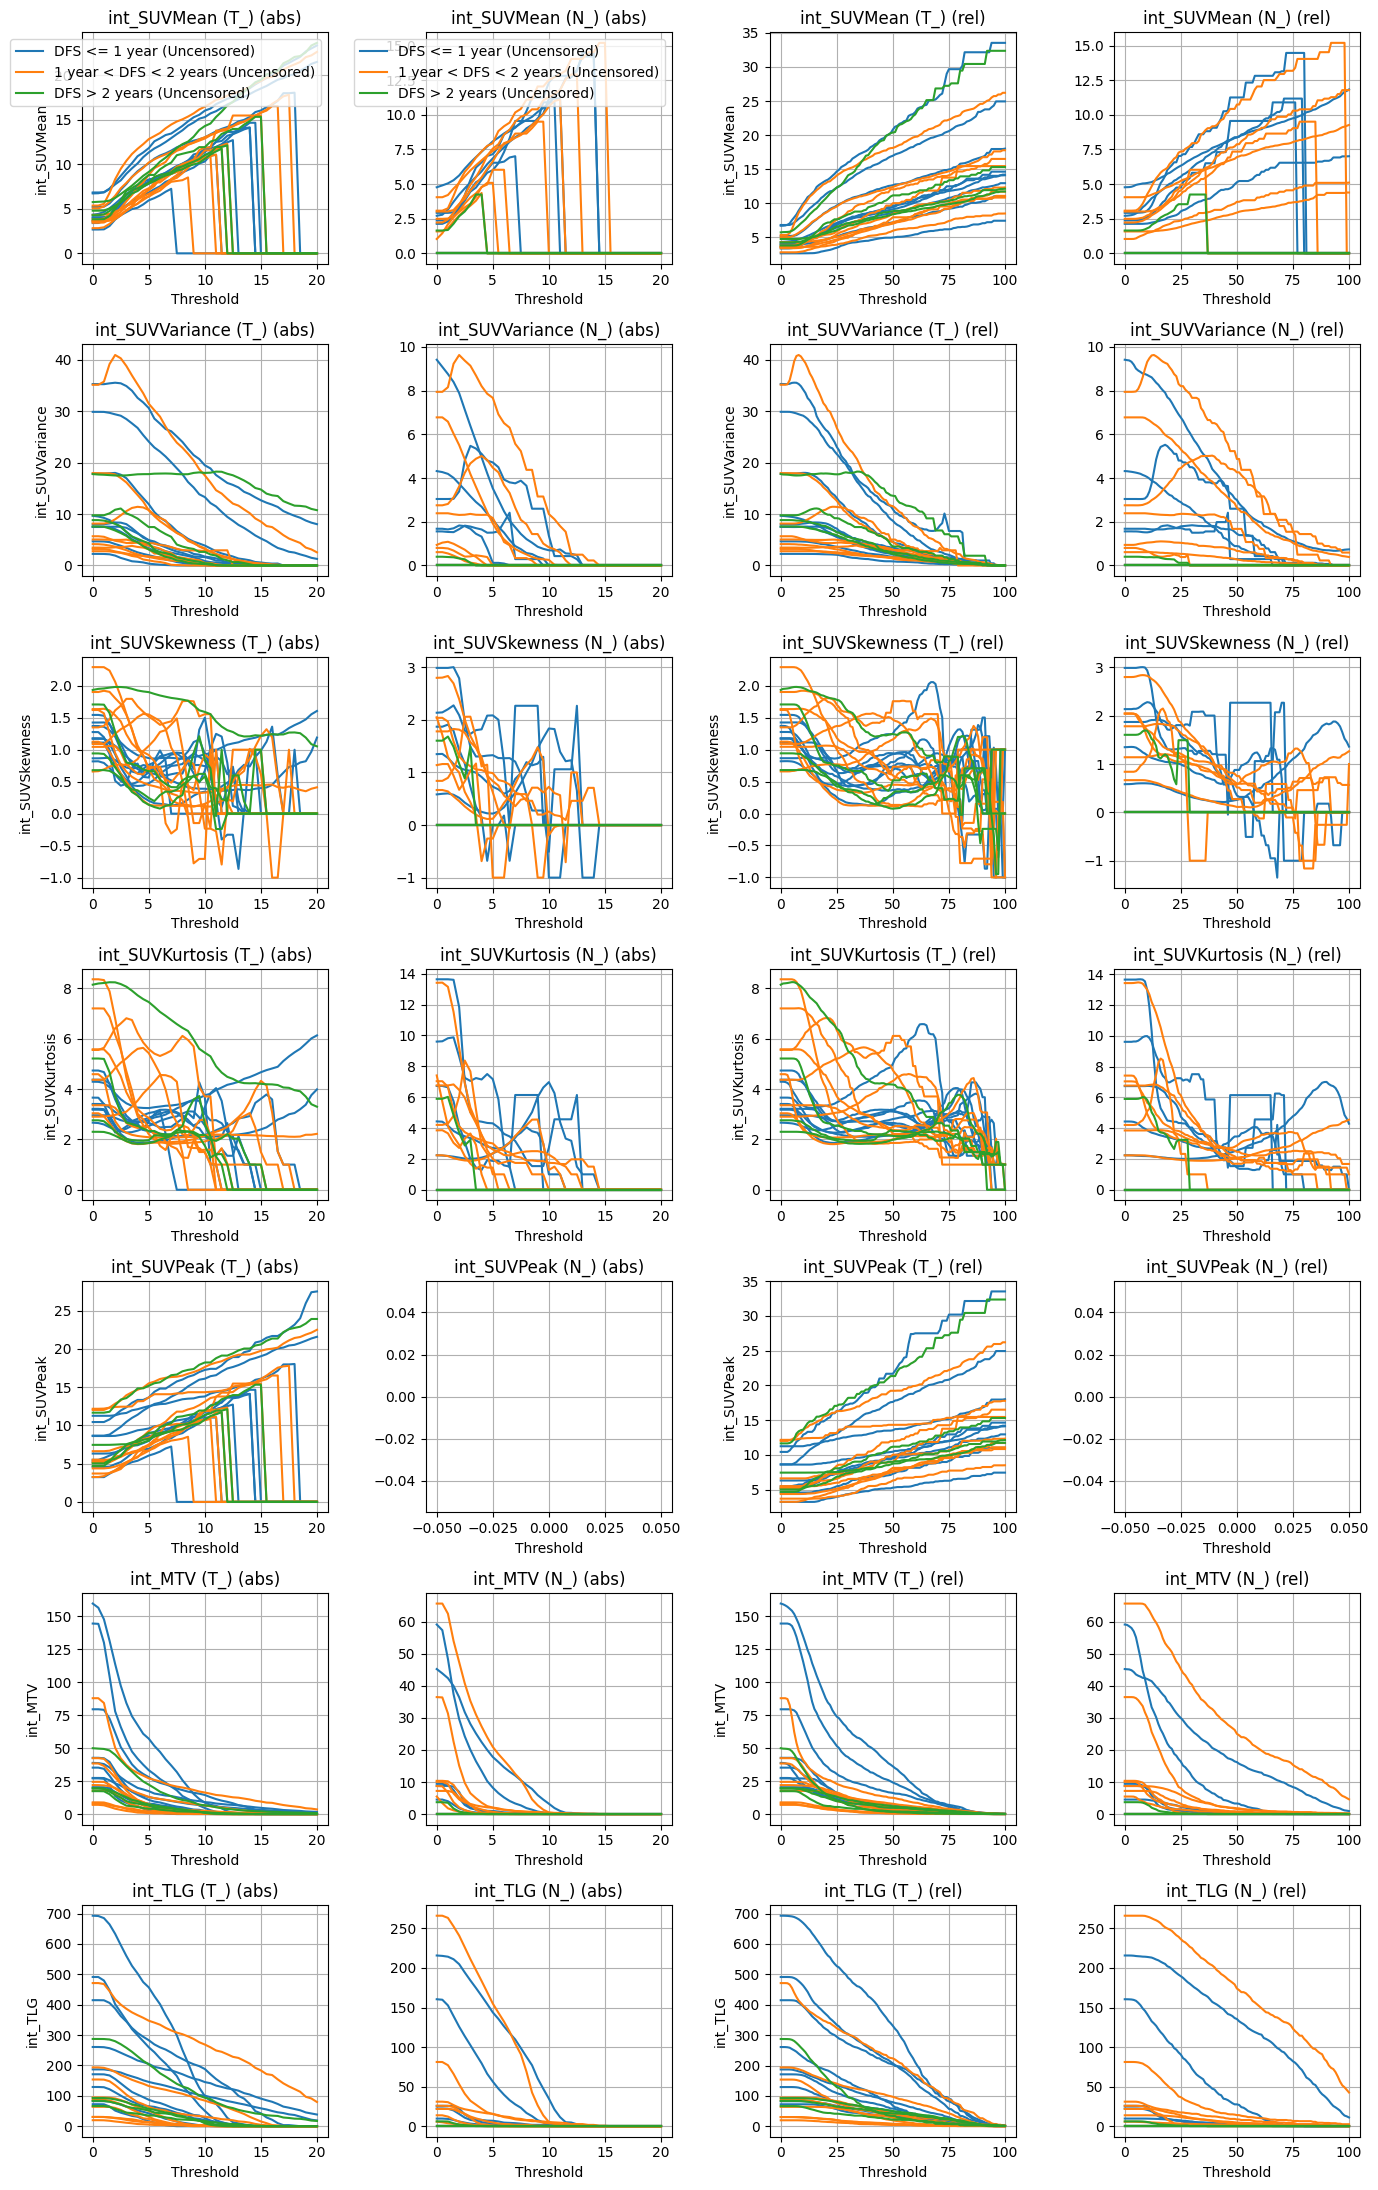

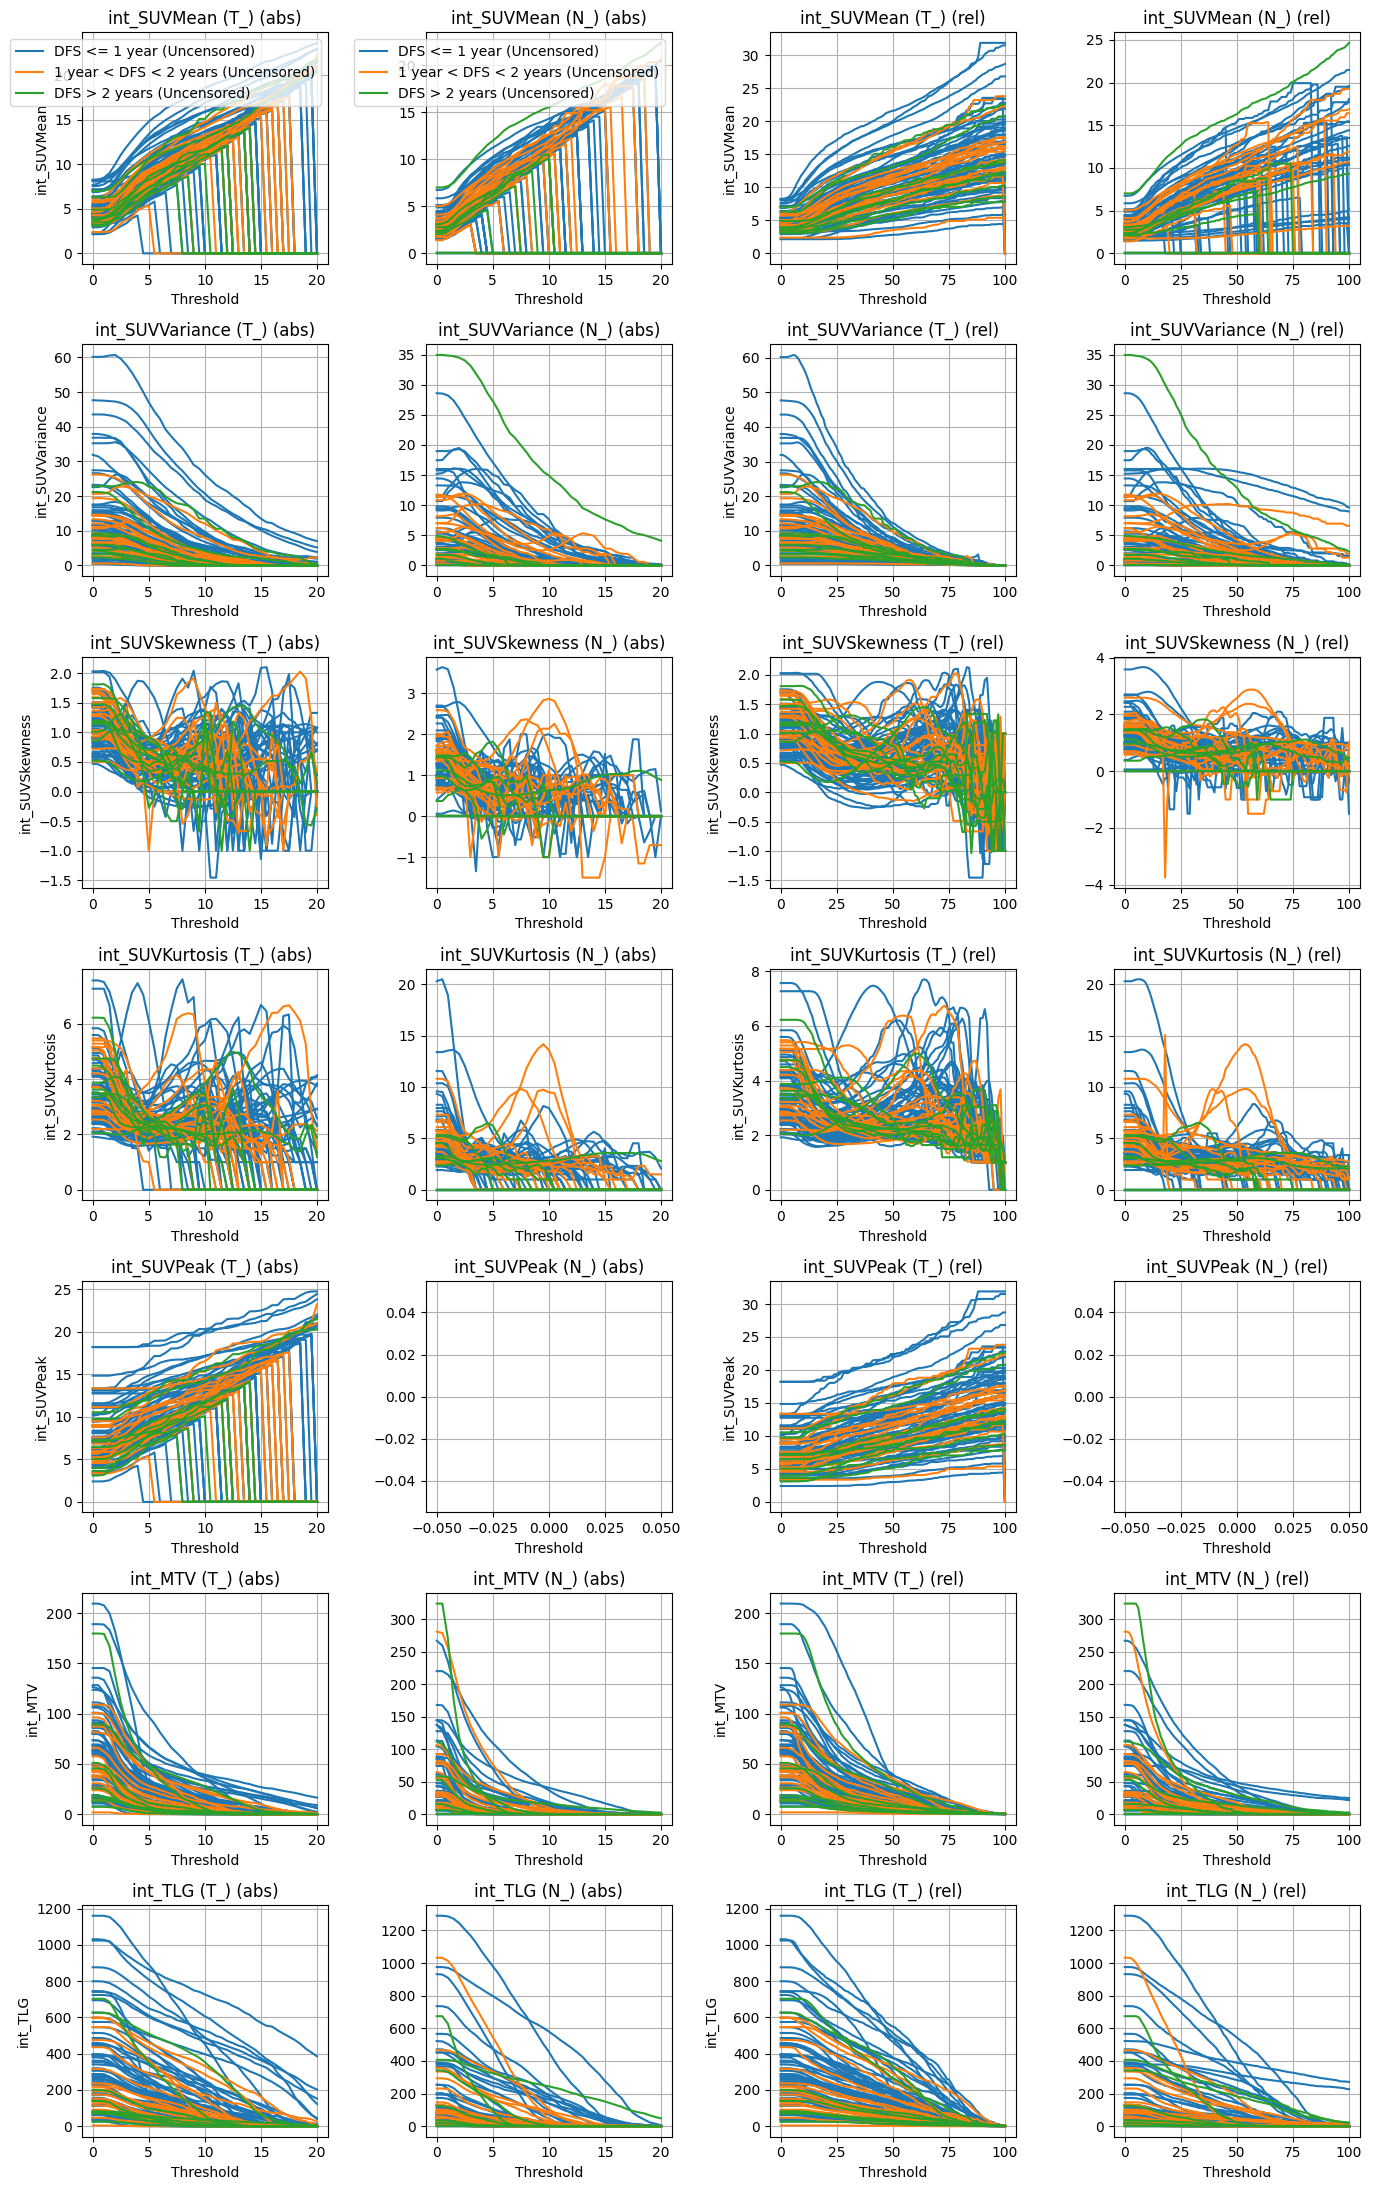

In [10]:
# Define features and comps
features = [
    'int_SUVMean', 'int_SUVVariance', 'int_SUVSkewness', 'int_SUVKurtosis',
    'int_SUVPeak', 'int_MTV', 'int_TLG'
]
comps = ['abs', 'rel']
# Create figures and axes for each stade
fig_stade_3, axs_stade_3 = plt.subplots(len(features), 4, figsize=(14, 22))  # 4 columns per row for each feature
fig_stade_4, axs_stade_4 = plt.subplots(len(features), 4, figsize=(14, 22))  # 4 columns per row for each feature

# Create plot matrices for each stade
create_plot_matrix_by_DFS_no_censor(df_rem, 3, axs_stade_3)
create_plot_matrix_by_DFS_no_censor(df_rem, 4, axs_stade_4)

# Adjust layout to prevent overlapping
fig_stade_3.tight_layout()
fig_stade_4.tight_layout()

# Show the plots
plt.show()

### Feture extraction functions

In [13]:
# Function to calculate the maximum value of the curve and its index
def calculate_max(values):
    """
    Calculate the maximum value of the curve, its index, and the corresponding threshold.

    Args:
    values (array): The corresponding feature values across thresholds.

    Returns:
    max_value (float): Maximum value of the curve.
    max_index (int): Index of the maximum value.
    max_tresh (float): Threshold at which the maximum occurs (assuming threshold indices are spaced by 0.5).
    """
    return np.max(values), np.argmax(values), np.argmax(values) / 2

# Function to find the index where the curve starts increasing after being flat
def find_start_of_increase(values):
    """
    Find the index where the curve starts to increase after being flat or constant.

    Args:
    values (array): The corresponding feature values across thresholds.

    Returns:
    start_idx (int): The index where the first increase occurs, or 0 if no increase is found.
    """
    for i in range(1, len(values)):
        if values[i] > values[i-1]:  # First increase
            return i
    return 0  # If no increase is found, return the first index

# Function to calculate the slope between the start of the increase and the maximum value
def up_slope(thresholds, values):
    """
    Calculate the slope between the start of the increase and the maximum peak of the curve.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    slope (float): The slope between the start of the increase and the maximum peak. Returns 0 if the range is invalid.
    """
    start_idx = find_start_of_increase(values)
    max_value, max_idx, max_tresh = calculate_max(values)
    # Calculate the slope between start_idx and max_idx
    if max_idx > start_idx and thresholds[max_idx] != thresholds[start_idx]:
        slope = (values[max_idx] - values[start_idx]) / (thresholds[max_idx] - thresholds[start_idx])
        slope = round(slope, 3)
    else:
        slope = 0  # Return 0 if the range is invalid or flat

    return slope

# Function to calculate the area under the curve (AUC) using Simpson's rule
def calculate_auc(thresholds, values):
    """
    Calculate the area under the curve (AUC) using Simpson's rule.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    auc (float): The area under the curve.
    """
    auc = simps(values, thresholds)
    return round(auc, 3)

# Function to retrieve the value at a specific threshold
def get_value_at_threshold(thresholds, values, target_threshold):
    """
    Retrieve the value at a specific target threshold.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.
    target_threshold (float): The threshold at which to retrieve the value.

    Returns:
    value (float): The value at the target threshold, or NaN if not found.
    """
    idx = np.searchsorted(thresholds, target_threshold)
    if idx < len(thresholds):
        return values[idx]
    else:
        return np.nan  # If threshold not found

# Function to find the highest value in the first quarter of thresholds
def find_highest_in_first_quart(thresholds, values):
    """
    Find the highest value within the first quarter of thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    max_index (int): The index of the highest value in the first quarter.
    """
    halfq_index = len(thresholds) // 4
    max_index = np.argmax(values[:halfq_index])  # Max value in the first quarter
    return max_index

# Function to find the highest value in the second part of thresholds
def find_highest_in_second_part(thresholds, values):
    """
    Find the highest value within the second part (last 3/4) of thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    max_index (int): The index of the highest value in the second part.
    """
    halfq_index = len(thresholds) // 4
    max_index = np.argmax(values[halfq_index:])  # Max value in the second part
    return max_index

# Function to find the lowest value within the first quarter of thresholds
def find_lowest_in_first_quart(thresholds, values):
    """
    Find the lowest value within the first quarter of thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    min_index (int): The index of the lowest value in the first quarter.
    """
    halfq_index = len(thresholds) // 4
    min_index = np.argmin(values[:halfq_index])  # Min value in the first quarter
    return min_index

# Function to find the lowest value within the second part of thresholds
def find_lowest_in_second_part(thresholds, values):
    """
    Find the lowest value within the second part (last 3/4) of thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    min_index (int): The index of the lowest value in the second part.
    """
    halfq_index = len(thresholds) // 4
    min_index = np.argmin(values[halfq_index:])  # Min value in the second part
    return min_index

# Function to calculate the slope between the highest and lowest values in the first quarter of thresholds
def slope_first_quart(thresholds, values):
    """
    Calculate the slope between the highest and lowest values in the first quarter of thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    slope (float): The slope between the highest and lowest points in the first quarter, or 0 if invalid.
    """
    max_idx = find_highest_in_first_quart(thresholds, values)
    min_idx = find_lowest_in_first_quart(thresholds, values)

    # Ensure that the maximum value occurs before the minimum value
    if max_idx < min_idx and thresholds[max_idx] != thresholds[min_idx]:
        slope = (values[min_idx] - values[max_idx]) / (thresholds[min_idx] - thresholds[max_idx])
    else:
        slope = 0  # Return 0 if the range is invalid

    return slope

# Function to calculate the slope between the highest and lowest values in the second part of thresholds
def slope_second_part(thresholds, values):
    """
    Calculate the slope between the highest and lowest values in the second part of thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    slope (float): The slope between the highest and lowest points in the second part, or 0 if invalid.
    """
    max_idx = find_highest_in_second_part(thresholds, values)
    min_idx = find_lowest_in_second_part(thresholds, values)

    # Ensure that the maximum value occurs before the minimum value
    if max_idx < min_idx and thresholds[max_idx] != thresholds[min_idx]:
        slope = (values[min_idx] - values[max_idx]) / (thresholds[min_idx] - thresholds[max_idx])
    else:
        slope = 0  # Return 0 if the range is invalid

    return slope

# Function to calculate the area under the curve (AUC) for the first and second halves of thresholds
def calculate_auc_halves(thresholds, values):
    """
    Calculate the area under the curve (AUC) for the first and second halves of the thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    auc_first_half (float): AUC for the first half of the curve.
    auc_second_half (float): AUC for the second half of the curve.
    """
    halfway_index = len(thresholds) // 2
    first_half_values = values[:halfway_index]
    second_half_values = values[halfway_index:]
    first_half_thresholds = thresholds[:halfway_index]
    second_half_thresholds = thresholds[halfway_index:]

    auc_first_half = simps(first_half_values, first_half_thresholds)
    auc_second_half = simps(second_half_values, second_half_thresholds)

    return round(auc_first_half, 3), round(auc_second_half, 3)

# Function to calculate the overall fluctuation of the curve
def fluctuation(thresholds, values):
    """
    Calculate the overall fluctuation of the curve based on the rate of change (derivative).

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    fluctuation_feature (float): The total fluctuation of the curve, calculated as the sum of the absolute values of the derivative.
    """
    # Calculate the derivative (rate of change)
    derivative = np.diff(values) / np.diff(thresholds)

    # Calculate the total fluctuation as the sum of absolute values of the derivative
    fluctuation_feature = np.sum(np.abs(derivative))
    fluctuation_feature = round(fluctuation_feature, 3)

    return fluctuation_feature


# Function to calculate the slope between the highest and lowest points in the curve
def slope_highest_lowest(thresholds, values):
    """
    Calculate the slope between the highest and lowest points in the curve.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    slope (float): The slope between the highest and lowest points in the curve. Returns 0 if the highest and lowest points are the same or the thresholds are identical.
    """
    # Find the index of the highest and lowest values
    highest_idx = np.argmax(values)
    lowest_idx = np.argmin(values)

    # Calculate the slope between the highest and lowest points
    if highest_idx != lowest_idx and thresholds[highest_idx] != thresholds[lowest_idx]:
        slope = (values[lowest_idx] - values[highest_idx]) / (thresholds[lowest_idx] - thresholds[highest_idx])
        slope = round(slope, 3)
    else:
        slope = 0  # Return 0 if the highest and lowest are the same or thresholds are identical

    return slope


# Function to calculate the deviation of skewness from a normal distribution across thresholds
def skewness_acc_deviation_from_normal(thresholds, values):
    """
    Calculate the accumulated deviation of skewness from a normal distribution (where skewness is 0) across thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding skewness values across thresholds.

    Returns:
    skewness_deviation (float): The total deviation from normal skewness (0), calculated as the sum of absolute deviations.
    """
    # Calculate the absolute deviation from zero (normal distribution skewness)
    deviation_from_normal = np.abs(values - 0)  # Same as np.abs(values) because 0 is the normal skewness

    # Aggregate the deviations: sum
    skewness_deviation = np.sum(deviation_from_normal)  # Using sum as the aggregate
    skewness_deviation = round(skewness_deviation, 3)

    return skewness_deviation


# Function to count zero-crossings in the second half of the curve
def count_zero_crossings_in_second_half(thresholds, values):
    """
    Count the number of times the curve crosses zero (sign changes) in the second half of the thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding feature values across thresholds.

    Returns:
    zero_crossings_count (int): The number of zero crossings in the second half of the curve.
    """
    # Find the second half of the thresholds and values
    halfway_index = len(thresholds) // 2
    second_half_values = values[halfway_index:]

    # Count zero-crossings in the second half
    zero_crossings_count = 0
    for i in range(1, len(second_half_values)):
        # Check if the curve crosses zero (sign change)
        if (second_half_values[i-1] > 0 and second_half_values[i] < 0) or (second_half_values[i-1] < 0 and second_half_values[i] > 0):
            zero_crossings_count += 1

    return zero_crossings_count


# Function to calculate the sum of deviation from normal distribution in kurtosis
def calculate_kurtosis_deviation_sum(thresholds, values):
    """
    Calculate the total deviation from the normal kurtosis (which is 3) across thresholds.

    Args:
    thresholds (array): The threshold values.
    values (array): The corresponding kurtosis values across thresholds.

    Returns:
    kurtosis_deviation_sum (float): The sum of absolute deviations from the normal kurtosis (3).
    """
    # Calculate the absolute deviation from the normal distribution kurtosis (3)
    deviation_from_normal = np.abs(values - 3)

    # Sum the deviations to get a single feature
    kurtosis_deviation_sum = np.sum(deviation_from_normal)

    return kurtosis_deviation_sum

Create an empty dataframe with the subjects ID and iteratively add the other values to the dataframe

In [14]:
#Add each patient's respective ID
subject_ids = df_rem['ID'].values

ids = []
for index, subject in df_rem.iterrows():

  id = subject_ids[index]
  ids.append({
      'ID': id
  })

# Create a DataFrame from the list of results
df_new_feat = pd.DataFrame(ids,index=None)


#### SUVMean & SUVPeak

In [15]:
features = ['int_SUVMean_T_','int_SUVMean_N_','SUVPeak_T_']
comps= ['abs','rel']

# Loop through each feature and component
for feature in features:
  for comp in comps:

    # Create an empty list to store the results
    results = []

    for index, subject in df_rem.iterrows():

      feat = subject[df_rem.columns.str.contains(f'{feature}') & df_rem.columns.str.contains(f'{comp}')]
      # Extract thresholds from the index
      thresholds = [
          float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
          for key in feat.index
      ]

      # Extract values
      values = feat.values

      # Calculate the max, slope, and range
      max_value = calculate_max(values)[0]
      max_tresh = calculate_max(values)[2]
      slope_value = up_slope(thresholds, values)
      # Calculate the area under the curve (AUC)
      auc_value = calculate_auc(thresholds, values)
      #Calculate the value at 0 treshold
      zero_value = get_value_at_threshold(thresholds, values, 0)

        # Append the results to the list
      results.append({
          f'{feature}{comp}_MaxValue': max_value,
          f'{feature}{comp}_MaxThreshold': max_tresh,
          f'{feature}{comp}_Slope': slope_value,
          f'{feature}{comp}_AUC': auc_value,
          f'{feature}{comp}_ValueAt0': zero_value
      })

    # Create a DataFrame from the list of results
    result = pd.DataFrame(results,index=None)

    #Join with existing dataframe
    df_new_feat = pd.concat([df_new_feat, result], axis=1)



### MTV

In [16]:
features = ['int_MTV_T_','int_MTV_N_']
comps = ['abs','rel']


# Loop through each feature and component
for feature in features:
  for comp in comps:
    results = []

    for index, subject in df_rem.iterrows():

      feat = subject[df_rem.columns.str.contains(f'{feature}') & df_rem.columns.str.contains(f'{comp}')]
      # Extract thresholds from the index
      thresholds = [
          float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
          for key in feat.index
      ]
      # Extract values
      values = feat.values

      #calculate slope
      slope_fristq = slope_first_quart(thresholds, values)
      slope_secondq = slope_second_part(thresholds, values)
      max_value = calculate_max(values)[0]
      # Calculate the area under the curve (AUC)
      auc_value = calculate_auc(thresholds, values)

       # Append the results to the list
      results.append({
          f'{feature}{comp}_SlopeFirstQ': slope_fristq,
          f'{feature}{comp}_SlopeSecondPart': slope_secondq,
          f'{feature}{comp}_MaxValue': max_value,
          f'{feature}{comp}_AUC': auc_value,
      })

    # Create a DataFrame from the list of results
    result = pd.DataFrame(results,index=None)

    #Join with existing dataframe
    df_new_feat = pd.concat([df_new_feat, result], axis= 1)

SUVVariance

In [17]:
features = ['int_SUVVariance_T_','int_SUVVariance_N_']
comps = ['abs','rel']

# Loop through each feature and component
for feature in features:
  for comp in comps:
    results = []
    for index, subject in df_rem.iterrows():
      feat = subject[df_rem.columns.str.contains(f'{feature}') & df_rem.columns.str.contains(f'{comp}')]
      # Extract thresholds from the index
      thresholds = [
          float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
          for key in feat.index
      ]
      # Extract values
      values = feat.values

      max_value = calculate_max(values)[0]
      auc_first_half, auc_second_half = calculate_auc_halves(thresholds, values)
      fluctuation_feature = fluctuation(thresholds, values)
      slope = slope_highest_lowest(thresholds, values)
      # Append the results to the list
      results.append({
          f'{feature}{comp}_MaxValue': max_value,
          f'{feature}{comp}_AUC_FirstHalf': auc_first_half,
          f'{feature}{comp}_AUC_SecondHalf': auc_second_half,
          f'{feature}{comp}_Fluctuation': fluctuation_feature,
          f'{feature}{comp}_Slope': slope,

      })



    # Create a DataFrame from the list of results
    result = pd.DataFrame(results,index=None)

    #Join with existing dataframe
    df_new_feat = pd.concat([df_new_feat, result], axis= 1)

TLG

In [18]:
features = ['int_TLG_T_','int_TLG_N_']
comps = ['abs','rel']

# Loop through each feature and component
for feature in features:
  for comp in comps:
    results = []
    for index, subject in df_rem.iterrows():
      feat = subject[df_rem.columns.str.contains(f'{feature}') & df_rem.columns.str.contains(f'{comp}')]
      # Extract thresholds from the index
      thresholds = [
          float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
          for key in feat.index
      ]
      # Extract values
      values = feat.values

      max_value = calculate_max(values)[0]
      slope = slope_highest_lowest(thresholds, values)
      # Calculate the area under the curve (AUC)
      auc_value = calculate_auc(thresholds, values)
      if comp == 'abs':
        half_value = get_value_at_threshold(thresholds, values, 10)
      elif comp == 'rel':
        half_value = get_value_at_threshold(thresholds, values, 50)

      # Append the results to the list
      results.append({
          f'{feature}{comp}_MaxValue': max_value,
          f'{feature}{comp}_Slope': slope,
          f'{feature}{comp}_AUC': auc_value,
          f'{feature}{comp}_ValueAtHalf': half_value

      })



    # Create a DataFrame from the list of results
    result = pd.DataFrame(results,index=None)
    #Join with existing dataframe
    df_new_feat = pd.concat([df_new_feat, result], axis= 1)

Skewness

In [19]:
features = ['int_SUVSkewness_T_','int_SUVSkewness_N_']
comps = ['abs','rel']

# Loop through each feature and component
for feature in features:
  for comp in comps:
    results = []
    for index, subject in df_rem.iterrows():
      feat = subject[df_rem.columns.str.contains(f'{feature}') & df_rem.columns.str.contains(f'{comp}')]
      # Extract thresholds from the index
      thresholds = [
          float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
          for key in feat.index
      ]
      # Extract values
      values = feat.values

      dev_from_normal = skewness_acc_deviation_from_normal(thresholds, values)
      zero_crossings = count_zero_crossings_in_second_half(thresholds, values)

      # Append the results to the list
      results.append({
          f'{feature}{comp}_AccumDevFromNormal': dev_from_normal,
          f'{feature}{comp}_AccumZeroCrossingSecondHalf': zero_crossings,

      })


    # Create a DataFrame from the list of results
    result = pd.DataFrame(results,index=None)
    #Join with existing dataframe
    df_new_feat = pd.concat([df_new_feat, result], axis= 1)

Kurtosis

In [20]:
features = ['int_SUVKurtosis_T_','int_SUVKurtosis_N_']
comps = ['abs','rel']

# Loop through each feature and component
for feature in features:
  for comp in comps:
    results = []
    for index, subject in df_rem.iterrows():
      feat = subject[df_rem.columns.str.contains(f'{feature}') & df_rem.columns.str.contains(f'{comp}')]
      # Extract thresholds from the index
      thresholds = [
          float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
          for key in feat.index
      ]
      # Extract values
      values = feat.values

      dev_from_normal = calculate_kurtosis_deviation_sum(thresholds, values)
      fluctuation_feature = fluctuation(thresholds, values)

      # Append the results to the list
      results.append({
          f'{feature}{comp}_AccumDevFromNormal': dev_from_normal,
          f'{feature}{comp}_Fluctuation': fluctuation_feature,

      })


    # Create a DataFrame from the list of results
    result = pd.DataFrame(results,index=None)
    #Join with existing dataframe
    df_new_feat = pd.concat([df_new_feat, result], axis= 1)

In [21]:
df_new_feat

,ID,int_SUVMean_T_abs_MaxValue,int_SUVMean_T_abs_MaxThreshold,int_SUVMean_T_abs_Slope,int_SUVMean_T_abs_AUC,int_SUVMean_T_abs_ValueAt0,int_SUVMean_T_rel_MaxValue,int_SUVMean_T_rel_MaxThreshold,int_SUVMean_T_rel_Slope,int_SUVMean_T_rel_AUC,...,int_SUVSkewness_N_rel_AccumDevFromNormal,int_SUVSkewness_N_rel_AccumZeroCrossingSecondHalf,int_SUVKurtosis_T_abs_AccumDevFromNormal,int_SUVKurtosis_T_abs_Fluctuation,int_SUVKurtosis_T_rel_AccumDevFromNormal,int_SUVKurtosis_T_rel_Fluctuation,int_SUVKurtosis_N_abs_AccumDevFromNormal,int_SUVKurtosis_N_abs_Fluctuation,int_SUVKurtosis_N_rel_AccumDevFromNormal,int_SUVKurtosis_N_rel_Fluctuation
0,6,10.4864,10.0,0.809,68.899,2.7872,10.4864,47.0,0.086,683.757,...,40.583,0,89.4014,14.883,142.9893,7.460,124.5693,37.347,325.0943,18.277
1,7,11.1885,11.0,0.669,87.391,4.1619,11.2911,50.0,0.075,786.765,...,71.179,1,75.4370,7.980,96.6676,4.477,82.8594,23.955,127.3532,12.309
2,8,11.3876,11.0,0.725,85.637,4.0387,11.3876,48.0,0.081,773.843,...,0.000,0,69.6774,12.290,71.4915,5.176,123.0000,0.000,303.0000,0.000
3,9,8.9978,8.5,0.750,51.006,2.9925,8.9978,45.5,0.071,583.679,...,0.000,0,82.5040,15.231,80.6129,6.995,123.0000,0.000,303.0000,0.000
4,10,7.1270,6.5,0.665,36.016,3.4674,7.1834,50.0,0.043,502.555,...,140.744,0,87.4401,10.548,63.7792,5.384,98.8435,17.810,202.0930,6.676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,178,15.5600,15.0,0.756,165.745,5.3500,15.6000,50.0,0.114,1039.877,...,100.170,1,49.0300,9.180,70.0900,4.590,109.5100,13.200,145.7400,7.700
230,181,7.0400,7.0,0.735,33.772,2.5700,7.0600,50.0,0.051,467.477,...,109.490,3,90.6900,10.200,79.8300,5.940,90.8800,12.900,150.4600,6.950
231,190,12.6500,12.5,0.722,109.477,4.3400,12.7300,50.0,0.091,848.983,...,73.910,3,70.3400,10.560,99.5700,6.200,87.7300,14.800,71.4000,9.800
232,191,14.5400,14.5,0.837,139.855,3.2300,14.5400,48.5,0.124,933.517,...,83.760,2,80.9300,18.420,157.9800,9.310,90.9200,21.300,148.4400,11.290


In [30]:
# access to suv_feat columns' names like ' int_SUVPeak_T_9abs ' and organize them in a list
# Define the features and comps
features = [
    'int_SUVMean_T_', 'int_SUVMean_N_', 'int_SUVVariance_T_', 'int_SUVVariance_N_',
    'int_SUVSkewness_T_', 'int_SUVSkewness_N_', 'int_SUVKurtosis_T_', 'int_SUVKurtosis_N_',
    'int_SUVPeak_T_', 'int_MTV_T_', 'int_MTV_N_', 'int_TLG_T_',
    'int_TLG_N_'
]

comps = ['abs', 'rel']

column_names = []
for feature in features:
  for comp in comps:
    for index, subject in df_rem.iterrows():
      feat = subject[df_rem.columns.str.contains(f'{feature}') & df_rem.columns.str.contains(f'{comp}')]
      for col in feat.index:
        if col not in column_names:
          column_names.append(col)
column_names.append('ID')


In [23]:
#  dataframe with df_rem except the columns in columns_names
df_non_suv = df_rem.drop(columns=column_names)


In [24]:
df_new_feat = pd.concat([df_non_suv,df_new_feat], axis= 1)

### Save the dataset

In [28]:
df_new_feat.to_excel(f'{folder_datasets}/df_new.xlsx', index=False)

In [29]:
df_new_feat.to_csv(f'{folder_datasets}/df_new.csv', index=False)